<a href="https://colab.research.google.com/github/shubham1m/MusicGeneration/blob/main/MusicWithLSTM_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Training

In [2]:
import os
import pickle
import numpy

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

!cp /content/drive/MyDrive/ColabNotebooks/models/RNNAttention.py .
from RNNAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, create_network

##Set params

In [3]:
# run params
section = '/content/drive/MyDrive/ColabNotebooks/MusicGeneration/MusicWithLSTM_Data'
music_name = 'classical'

run_folder = '{}/'.format(section)
#run_folder += '_'.join([run_id, music_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join(section, music_name)

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    


mode = 'build' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True

In [4]:
print(data_folder)
print(store_folder)

/content/drive/MyDrive/ColabNotebooks/MusicGeneration/MusicWithLSTM_Data/classical
/content/drive/MyDrive/ColabNotebooks/MusicGeneration/MusicWithLSTM_Data/store


##Extract Notes

In [ ]:
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))
                        durations.append(element.duration.quarterLength)

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f) 
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f)

##Lookup table

In [ ]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [ ]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A0': 0,
 'A0.A1.A2.A3': 1,
 'A1': 2,
 'A1.A2': 3,
 'A1.A2.A3': 4,
 'A1.A2.A3.A4': 5,
 'A1.A2.A3.B3.D4.A4': 6,
 'A1.A2.A3.B4': 7,
 'A1.A2.A3.C#4': 8,
 'A1.A2.A3.C#4.A4': 9,
 'A1.A2.A3.C#4.A4.C#5': 10,
 'A1.A2.A3.C#4.E-4.A4': 11,
 'A1.A2.A3.C#4.E4': 12,
 'A1.A2.A3.C#4.E4.A4': 13,
 'A1.A2.A3.C#4.E4.A4.A5.C#6.E6.A6': 14,
 'A1.A2.A3.C#4.E4.G4': 15,
 'A1.A2.A3.C#4.F#4': 16,
 'A1.A2.A3.C#4.F#4.A4': 17,
 'A1.A2.A3.C#4.F4': 18,
 'A1.A2.A3.C4': 19,
 'A1.A2.A3.C4.E-4.A4': 20,
 'A1.A2.A3.C4.E4': 21,
 'A1.A2.A3.C4.E4.A4': 22,
 'A1.A2.A3.C4.E4.C5': 23,
 'A1.A2.A3.C4.E4.E5': 24,
 'A1.A2.A3.C4.F#4': 25,
 'A1.A2.A3.C4.F4': 26,
 'A1.A2.A3.D4': 27,
 'A1.A2.A3.D4.F#4': 28,
 'A1.A2.A3.D4.F#4.A4': 29,
 'A1.A2.A3.D4.F#4.A4.D5.F#5.A5': 30,
 'A1.A2.A3.E4': 31,
 'A1.A2.A3.E4.A4': 32,
 'A1.A2.A3.F#4': 33,
 'A1.A2.A3.G4': 34,
 'A1.A2.A3.G4.B4.E5': 35,
 'A1.A2.A3.G4.C#5.E5': 36,
 'A1.A2.A4': 37,
 'A1.A2.A4.A5': 38,
 'A1.A2.A4.C#5.A5': 39,
 'A1.A2.A4.C#5.A5.C#6': 40,
 'A1.A2.A4.C#5.E5.A5': 41,
 'A1.A2.A4.C#5.E5.G

In [ ]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 Fraction(7, 12): 7,
 Fraction(2, 3): 8,
 0.75: 9,
 Fraction(5, 6): 10,
 Fraction(11, 12): 11,
 1.0: 12,
 Fraction(13, 12): 13,
 Fraction(7, 6): 14,
 1.25: 15,
 Fraction(4, 3): 16,
 Fraction(17, 12): 17,
 1.5: 18,
 Fraction(5, 3): 19,
 1.75: 20,
 Fraction(23, 12): 21,
 2.0: 22,
 2.25: 23,
 Fraction(7, 3): 24,
 2.5: 25,
 2.75: 26,
 Fraction(17, 6): 27,
 Fraction(35, 12): 28,
 3.0: 29,
 3.25: 30,
 Fraction(41, 12): 31,
 3.5: 32,
 3.75: 33,
 4.0: 34,
 4.25: 35,
 Fraction(13, 3): 36,
 4.5: 37,
 5.0: 38,
 5.25: 39,
 Fraction(65, 12): 40,
 5.5: 41,
 6.0: 42,
 6.5: 43,
 6.75: 44,
 Fraction(41, 6): 45,
 8.0: 46}

##Prepare data for NN

In [ ]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [ ]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])

pitch input
[108 382 275 382 214 382 275 382 108 382 275 382 214 382 275 382 130 331
 385 331 273 331 385 331 130 331 385 331 273 331 385 331]
duration input
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
pitch output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

##Create NN

In [ ]:
model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    39900       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 100)    800         input_4[0][0]                    
____________________________________________________________________________________________

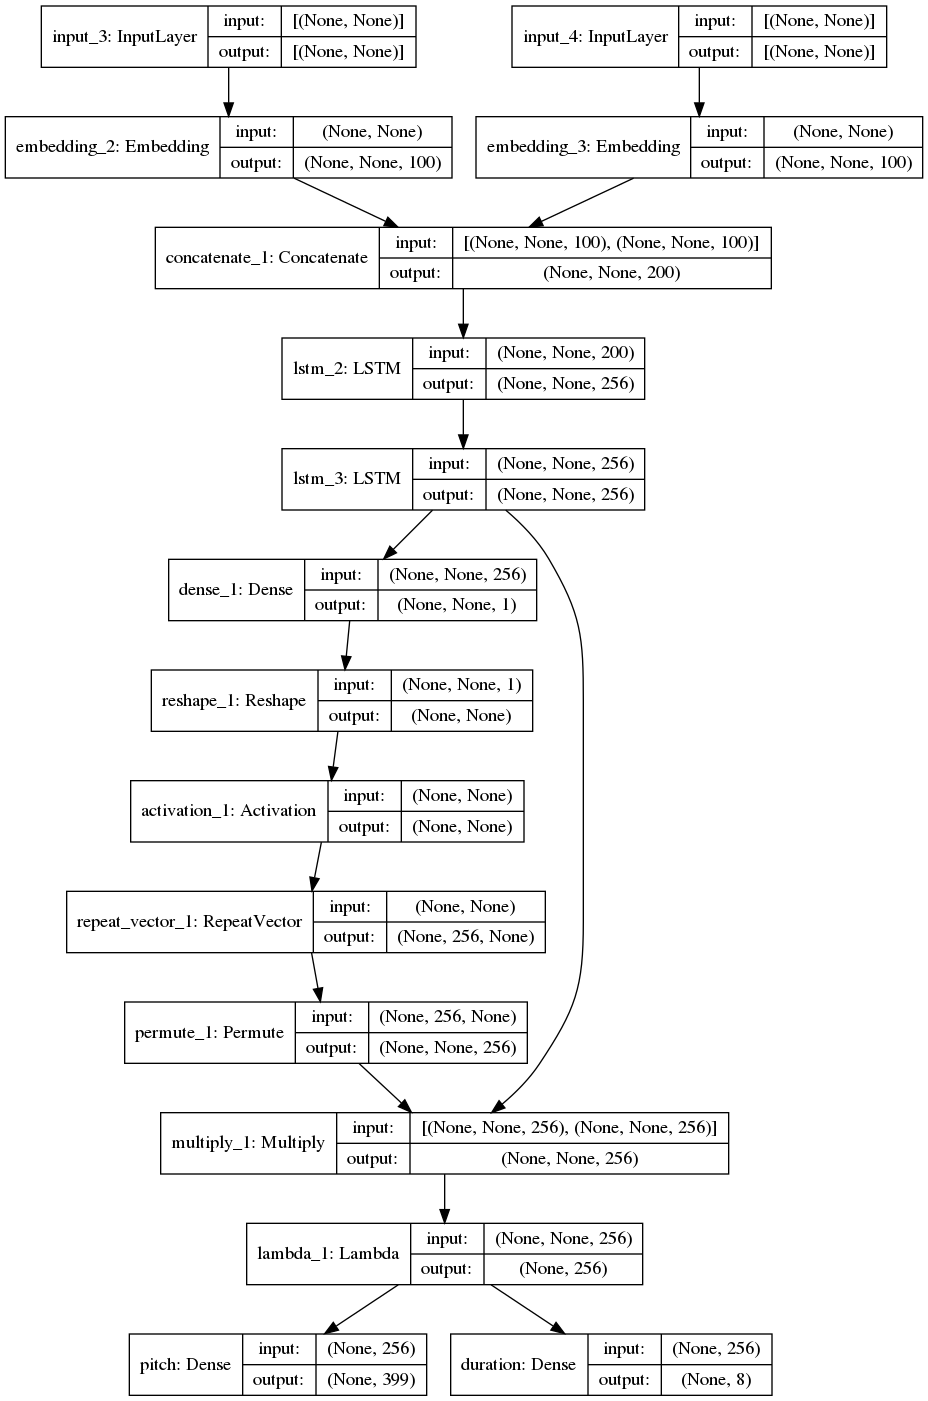

In [ ]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

##Train NN

In [ ]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [ ]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
model.fit(network_input, network_output
          , epochs=2000000, batch_size=32
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )

Epoch 1/2000000
26/26 [==============================] - 16s 427ms/step - loss: 6.3055 - pitch_loss: 5.6476 - duration_loss: 0.6579 - val_loss: 7.0115 - val_pitch_loss: 6.6353 - val_duration_loss: 0.3761
Epoch 2/2000000
26/26 [==============================] - 10s 375ms/step - loss: 5.0741 - pitch_loss: 4.8869 - duration_loss: 0.1872 - val_loss: 7.2824 - val_pitch_loss: 6.8768 - val_duration_loss: 0.4056
Epoch 3/2000000
26/26 [==============================] - 9s 362ms/step - loss: 4.9142 - pitch_loss: 4.7292 - duration_loss: 0.1850 - val_loss: 7.1723 - val_pitch_loss: 6.7843 - val_duration_loss: 0.3880
Epoch 4/2000000
26/26 [==============================] - 10s 366ms/step - loss: 4.8540 - pitch_loss: 4.6635 - duration_loss: 0.1906 - val_loss: 8.2774 - val_pitch_loss: 7.8923 - val_duration_loss: 0.3850
Epoch 5/2000000
26/26 [==============================] - 10s 378ms/step - loss: 4.5746 - pitch_loss: 4.3723 - duration_loss: 0.2022 - val_loss: 9.0951 - val_pitch_loss: 8.6459 - val_dur